In [1]:
import pandas as pd

# **Data for prediction**

- feature would be open | high | low | close | adj close | volume
- target value is Close

In [2]:
df = pd.read_csv('../data/price.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2018-12-03,46.115002,46.235001,45.302502,46.205002,44.595947,163210000,AAPL
1,2018-12-04,45.237499,45.597500,44.067501,44.172501,42.634228,165377200,AAPL
2,2018-12-06,42.939999,43.695000,42.605000,43.680000,42.158878,172393600,AAPL
3,2018-12-07,43.372501,43.622501,42.075001,42.122501,40.655613,169126400,AAPL
4,2018-12-10,41.250000,42.522499,40.832500,42.400002,40.923454,248104000,AAPL


## Select Ticker
- The data frame above include many difference ticker, choose 1 for a model

In [3]:
df = df.loc[df['Ticker']=='AAPL']
df

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2018-12-03,46.115002,46.235001,45.302502,46.205002,44.595947,163210000,AAPL
1,2018-12-04,45.237499,45.597500,44.067501,44.172501,42.634228,165377200,AAPL
2,2018-12-06,42.939999,43.695000,42.605000,43.680000,42.158878,172393600,AAPL
3,2018-12-07,43.372501,43.622501,42.075001,42.122501,40.655613,169126400,AAPL
4,2018-12-10,41.250000,42.522499,40.832500,42.400002,40.923454,248104000,AAPL
...,...,...,...,...,...,...,...,...
1003,2022-11-28,145.139999,146.639999,143.380005,144.220001,144.220001,69246000,AAPL
1004,2022-11-29,144.289993,144.809998,140.350006,141.169998,141.169998,83763800,AAPL
1005,2022-11-30,141.399994,148.720001,140.550003,148.029999,148.029999,111380900,AAPL
1006,2022-12-01,148.210007,149.130005,146.610001,148.309998,148.309998,71250400,AAPL


# Feature selection
- Choose one feature to predict themselves 

In [4]:
df = df[["Date", "Close"]]
df

,Date,Close
0,2018-12-03,46.205002
1,2018-12-04,44.172501
2,2018-12-06,43.680000
3,2018-12-07,42.122501
4,2018-12-10,42.400002
...,...,...
1003,2022-11-28,144.220001
1004,2022-11-29,141.169998
1005,2022-11-30,148.029999
1006,2022-12-01,148.309998


# Data preparation
- change the string date to date datatype

In [5]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2022-10-16')
datetime_object

datetime.datetime(2022, 10, 16, 0, 0)

**Change date datatype for all data frame**


In [6]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

/tmp/ipykernel_107113/2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      2018-12-03
1      2018-12-04
2      2018-12-06
3      2018-12-07
4      2018-12-10
          ...    
1003   2022-11-28
1004   2022-11-29
1005   2022-11-30
1006   2022-12-01
1007   2022-12-02
Name: Date, Length: 1008, dtype: datetime64[ns]

**Change the index of dataframe to date**

In [7]:
df.index = df.pop('Date')
df

,Close
Date,
2018-12-03,46.205002
2018-12-04,44.172501
2018-12-06,43.680000
2018-12-07,42.122501
2018-12-10,42.400002
...,...
2022-11-28,144.220001
2022-11-29,141.169998
2022-11-30,148.029999


# Visualize
- For overview and have a good vision to choose model

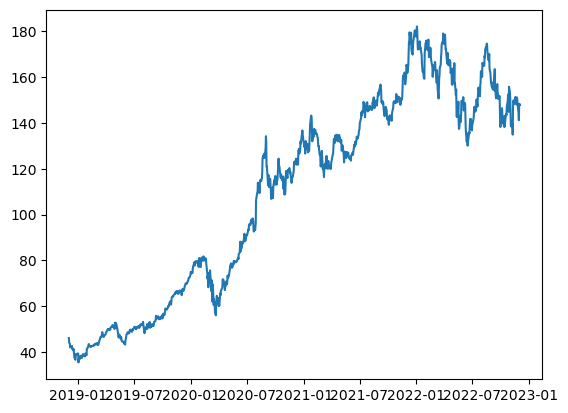

In [11]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

# Data processing
- Handle the data to fit for LSTM model
- Change to problem to supervisor learning (X, y)

In [28]:
import numpy as np

def df_to_sequential_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Sequential of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
sequential_df = df_to_sequential_df(df, 
                                '2018-12-10', 
                                '2022-12-01', 
                                n=3)
sequential_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-12-10,44.172501,43.680000,42.122501,42.400002
1,2018-12-11,43.680000,42.122501,42.400002,42.157501
2,2018-12-12,42.122501,42.400002,42.157501,42.275002
3,2018-12-13,42.400002,42.157501,42.275002,42.737499
4,2018-12-14,42.157501,42.275002,42.737499,41.369999
...,...,...,...,...,...
998,2022-11-25,148.009995,150.179993,151.070007,148.110001
999,2022-11-28,150.179993,151.070007,148.110001,144.220001
1000,2022-11-29,151.070007,148.110001,144.220001,141.169998
1001,2022-11-30,148.110001,144.220001,141.169998,148.029999


**Convert data frame to numpy array**

In [29]:
def sequential_df_to_date_X_y(sequential_dataframe):
  df_as_np = sequential_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = sequential_df_to_date_X_y(sequential_df)

dates.shape, X.shape, y.shape

((1003,), (1003, 3, 1), (1003,))

# Split data
- split the data to training, validation and test set with ratio 80%, 10%, 10%

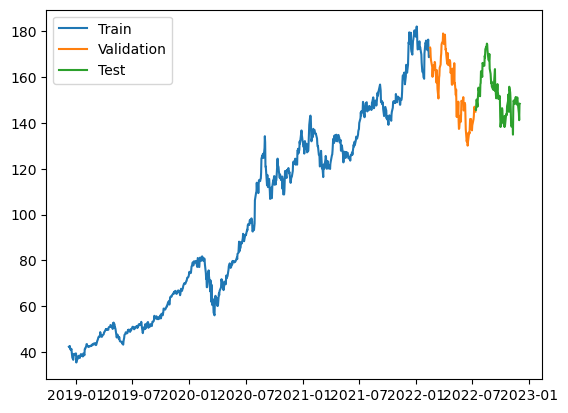

In [26]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# Training
- 3 layer LSTM model
- using mean sqrt error as loss function and activation function for each layer is ReLU

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)

Epoch 1/200
26/26 [==============================] - 6s 149ms/step - loss: 11002.1182 - mean_absolute_error: 96.2000 - val_loss: 23307.4121 - val_mean_absolute_error: 152.0999
Epoch 2/200
26/26 [==============================] - 0s 6ms/step - loss: 10013.9814 - mean_absolute_error: 90.7126 - val_loss: 20465.0742 - val_mean_absolute_error: 142.4464
Epoch 3/200
26/26 [==============================] - 0s 6ms/step - loss: 6905.1934 - mean_absolute_error: 70.3756 - val_loss: 12161.9502 - val_mean_absolute_error: 109.3956
Epoch 4/200
26/26 [==============================] - 0s 6ms/step - loss: 2377.7197 - mean_absolute_error: 40.7883 - val_loss: 2994.1548 - val_mean_absolute_error: 53.1408
Epoch 5/200
26/26 [==============================] - 0s 5ms/step - loss: 1465.6465 - mean_absolute_error: 34.6156 - val_loss: 2774.2979 - val_mean_absolute_error: 51.2110
Epoch 6/200
26/26 [==============================] - 0s 7ms/step - loss: 494.2563 - mean_absolute_error: 16.2240 - val_loss: 650.4149 -

# Prediction

**Predict on training dataset**

26/26 [==============================] - 1s 3ms/step


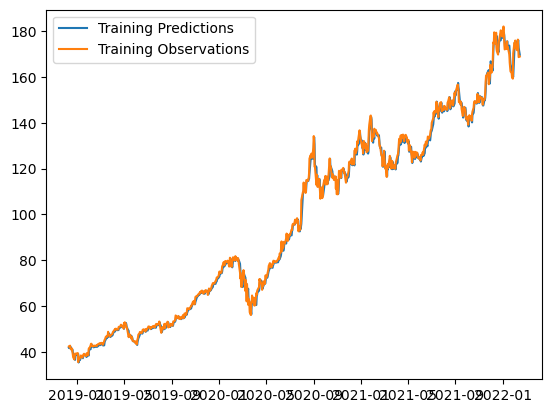

In [32]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

**Predict on validation dataset**

4/4 [==============================] - 0s 3ms/step


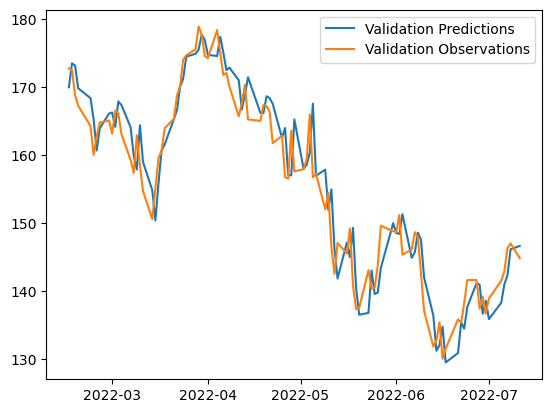

In [34]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

**Predict on testing dataset**

4/4 [==============================] - 0s 3ms/step


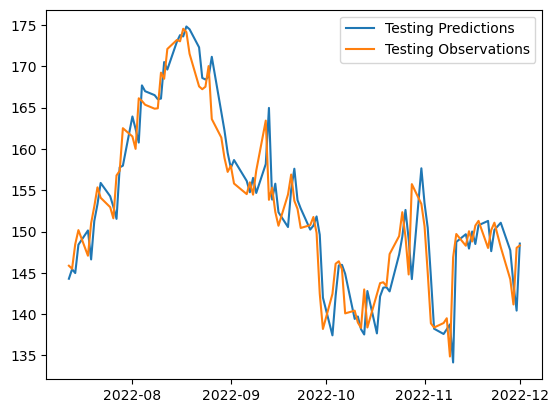

In [35]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

**Overview of prediction**

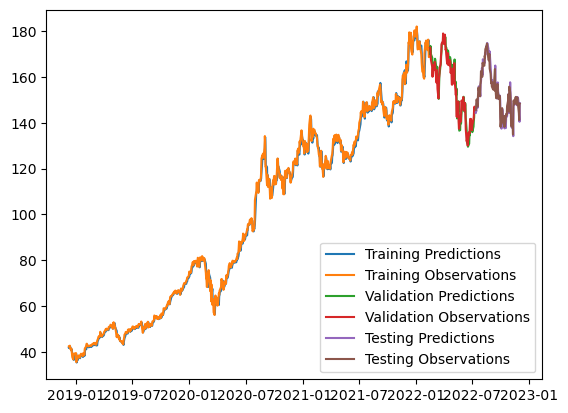

In [36]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

# Recursive predict on validation date and test date


**Cac du doan tren duoc thuc hien du tren cac data da co san trong tung ngay cua validation dataset va test dataset, recursive predict se tu du doan va bo sung vao data can thiet cho cac du doan tiep theo**

In [45]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_sequential = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_sequential])).flatten()
  recursive_predictions.append(next_prediction)
  last_sequential[-1] = next_prediction

1/1 [==============================] - 0s 19ms/step


**Overall Visualization**

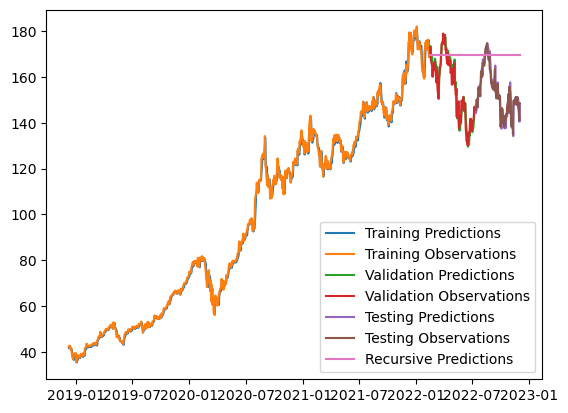

In [46]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

**Visualization without training dataset for easier observation**

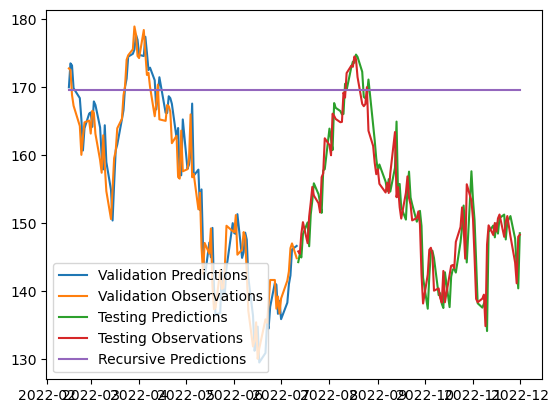

In [47]:

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])